Here we analyze the price data of FFR and FCR from the sheets

In [21]:
import pandas as pd
import numpy as np

In [22]:
df_fcr = pd.read_csv("data/FCR_2024.csv", on_bad_lines='skip', sep=';')

In [23]:
# modifications for nicer readibility
df_fcr.iloc[:, 1] = df_fcr.iloc[:, 1].replace(',', '.', regex=True).astype(float).round(2)
df_fcr = df_fcr.iloc[:-1 , :]
df_fcr["Datum"] = pd.to_datetime(df_fcr["Datum"], format='mixed')   #"%Y-%M-%D %H:%M:%S")  # 2025-02-01 22:00:00

In [24]:
df_ffr_2024 = pd.read_excel('data/FFR_2024.xlsx')
df_ffr_2023 = pd.read_excel('data/FFR_2023.xlsx')
df_ffr_2022 = pd.read_excel('data/FFR_2022.xlsx')
SEK_TO_EURO = 0.09

In [25]:
df_ffr_fingrid = pd.read_csv("data/FFR_Fingrid.csv", on_bad_lines='skip', sep=';')

In [26]:
def format_ffr(df, year_offset, name) -> pd.DataFrame:
    df.columns = df.iloc[1, :]
    df = df.iloc[2:, 0:2]
    df.iloc[:, 1:] = df.iloc[:, 1:].astype(float) * SEK_TO_EURO
    df.rename(columns={'Timme': 'Datum', 'Marginalpris (SEK/MW)': f'FFR (EUR/MW) {name}'}, inplace=True)
    df["Datum"] = pd.to_datetime(df["Datum"], format='mixed')
    # add one year because of year mismatch
    if year_offset:  df["Datum"] = df["Datum"] + pd.DateOffset(years=year_offset)
    return df

In [27]:
df_ffr_fingrid.drop('endTime', inplace=True, axis=1)
df_ffr_fingrid.rename(columns={'startTime': 'Datum', 'Fast Frequency Reserve FFR, price': 'FFR (EUR/MW) Fingrid'}, inplace=True)
df_ffr_fingrid["Datum"] = pd.to_datetime(df_ffr_fingrid["Datum"], format='mixed')

In [28]:
df_ffr_2024 = format_ffr(df_ffr_2024, year_offset=0, name='2024')
df_ffr_2023 = format_ffr(df_ffr_2023, year_offset=1, name='2023')
df_ffr_2022 = format_ffr(df_ffr_2022, year_offset=2, name='2022')
df_ffrs = [df_ffr_2024, df_ffr_2023, df_ffr_2022]

In [29]:
# merge
df_merged = df_fcr[['Datum', 'FCR-N Pris (EUR/MW)']]
for df in df_ffrs:
    df_merged = pd.merge(df_merged, df, on='Datum', how='left')

## FFR and FCR-N

<Axes: xlabel='Datum'>

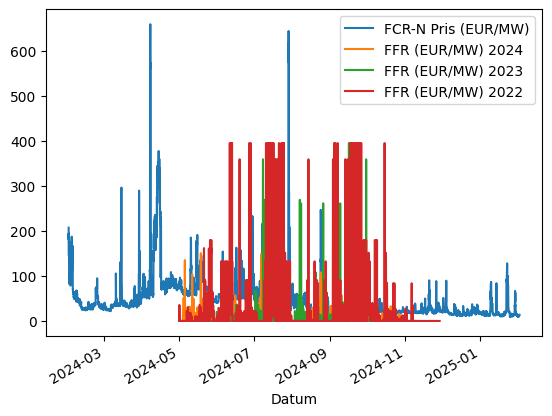

In [30]:
df_merged.plot(x='Datum')

C:\Users\carlv\AppData\Local\Temp\ipykernel_4900\751878038.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged_notna.fillna(0).plot(kind='hist', alpha=0.5, bins=30)


<Axes: ylabel='Frequency'>

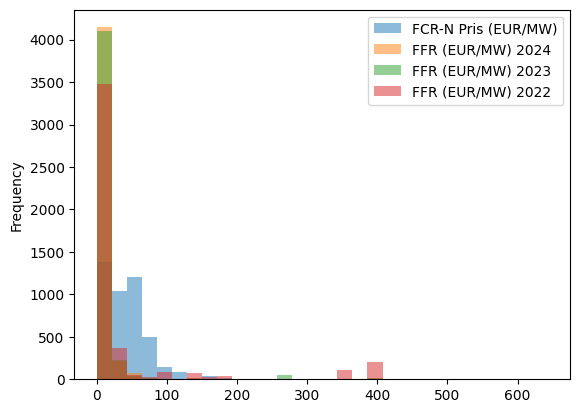

In [31]:
# make historgram with FFR prices
df_merged_notna = df_merged.dropna(subset=['FFR (EUR/MW) 2024', 'FFR (EUR/MW) 2023', 'FFR (EUR/MW) 2022'])
df_merged_notna.fillna(0).plot(kind='hist', alpha=0.5, bins=30)

C:\Users\carlv\AppData\Local\Temp\ipykernel_4900\3983047806.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged_notna['FCR-N Pris (EUR/MW)'].fillna(0).plot(kind='hist', alpha=0.5, bins=30)


<Axes: ylabel='Frequency'>

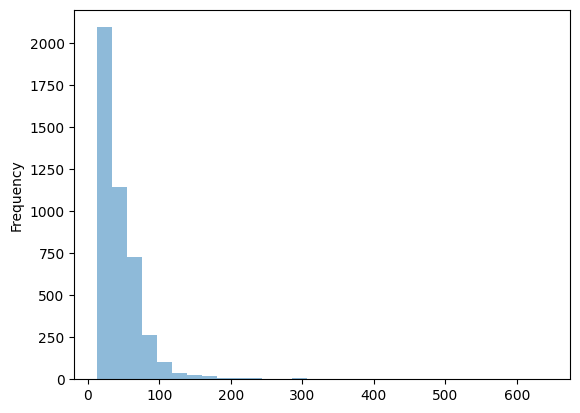

In [32]:
df_merged_notna['FCR-N Pris (EUR/MW)'].fillna(0).plot(kind='hist', alpha=0.5, bins=30)

<Axes: xlabel='Datum'>

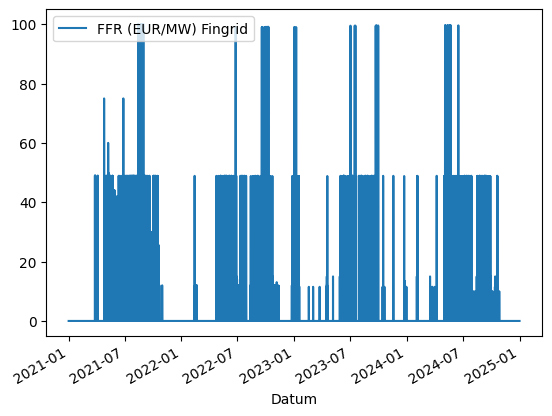

In [33]:
df_ffr_fingrid.plot(x='Datum', y='FFR (EUR/MW) Fingrid')

## mean values comparison

In [34]:
pd.options.display.float_format = '{:,.3f}'.format
print("Mean of Fingrid price EUR/MW:", df_ffr_fingrid['FFR (EUR/MW) Fingrid'].mean())
print("Mean of p>0 Fingrid price EUR/MW:", df_ffr_fingrid[df_ffr_fingrid['FFR (EUR/MW) Fingrid'] > 0]['FFR (EUR/MW) Fingrid'].mean())

Mean of Fingrid price EUR/MW: 5.187817228595891
Mean of p>0 Fingrid price EUR/MW: 33.2566988090011


In [35]:
df_merged.describe()

,Datum
count,8810
mean,2024-08-02 12:32:47.952326912
min,2024-02-01 00:00:00
25%,2024-05-02 19:15:00
50%,2024-08-02 13:30:00
75%,2024-11-02 04:45:00
max,2025-02-01 23:00:00


In [36]:
df_merged.fillna(0).describe()

C:\Users\carlv\AppData\Local\Temp\ipykernel_4900\858709426.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged.fillna(0).describe()


,Datum,FCR-N Pris (EUR/MW),FFR (EUR/MW) 2024,FFR (EUR/MW) 2023,FFR (EUR/MW) 2022
count,8810,"8,810.000","8,810.000","8,810.000","8,810.000"
mean,2024-08-02 12:32:47.952326912,45.437,3.247,4.407,19.144
min,2024-02-01 00:00:00,8.640,0.000,0.000,0.000
25%,2024-05-02 19:15:00,19.660,0.000,0.000,0.000
50%,2024-08-02 13:30:00,30.880,0.000,0.000,0.000
75%,2024-11-02 04:45:00,54.932,0.000,0.000,0.000
max,2025-02-01 23:00:00,658.380,150.300,394.650,394.650
std,NaN,48.684,11.137,28.766,72.646


# FCR-D Upwards market analysis

In [37]:
df_fcrd = pd.read_csv("data/FCR-D_UP.csv", on_bad_lines='skip', sep=';')
df_fcrd.drop('endTime', inplace=True, axis=1)
df_fcrd.rename(columns={'startTime': 'Datum'}, inplace=True)
df_fcrd["Datum"] = pd.to_datetime(df_fcrd["Datum"], format='mixed')
df_fcrd.set_index('Datum', inplace=True)
cols = df_fcrd.columns.tolist()
cols = [c[len("Frequency Containment Reserve for Disturbances upwards regulation, "):] for c in cols]
df_fcrd.columns = cols
df_fcrd.head()

,received bids in the hourly market,nordic trade,reserve plans in the yearly market,procured volumes in the hourly market,hourly market prices
Datum,,,,,
2020-12-31 23:00:00+00:00,283.500,-163.300,365.700,94.900,3.000
2021-01-01 00:00:00+00:00,284.000,-164.800,366.700,95.400,3.000
2021-01-01 01:00:00+00:00,289.000,-164.700,366.600,95.400,3.000
2021-01-01 02:00:00+00:00,289.000,-165.600,367.500,95.400,3.000
2021-01-01 03:00:00+00:00,294.500,-172.600,369.000,100.900,3.000


array([[<Axes: xlabel='Datum'>, <Axes: xlabel='Datum'>,
        <Axes: xlabel='Datum'>],
       [<Axes: xlabel='Datum'>, <Axes: xlabel='Datum'>,
        <Axes: xlabel='Datum'>],
       [<Axes: xlabel='Datum'>, <Axes: xlabel='Datum'>,
        <Axes: xlabel='Datum'>]], dtype=object)

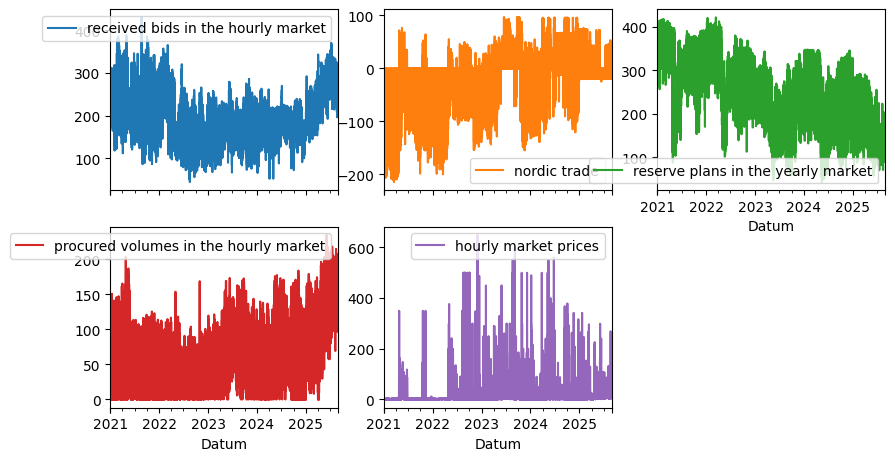

In [38]:
# plot
df_fcrd.plot(subplots=True, layout=(3,3), figsize=(10,8))

In [39]:
df_fcrd.describe()

,received bids in the hourly market,nordic trade,reserve plans in the yearly market,procured volumes in the hourly market,hourly market prices
count,"40,847.000","40,847.000","40,847.000","40,847.000","40,847.000"
mean,199.543,-29.372,250.291,64.345,15.798
std,56.538,56.664,77.798,41.789,43.321
min,43.900,-214.700,43.500,0.000,0.000
25%,158.000,-72.350,191.300,34.100,1.800
50%,191.200,0.000,255.500,60.300,2.840
75%,240.200,0.000,306.600,87.600,8.000
max,430.400,96.400,422.100,234.900,650.000
